In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_csv('C:/Users/keert/OneDrive/Desktop/Mini Project/resampled_lob_minALL.csv')


data.head()

,Datetime,Min Ask Price,Max Bid Price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity
0,2025-01-02 00:00:00,271.841538,260.186154,22881.0,16799.0,3,5
1,2025-01-02 00:01:00,262.803138,258.206847,24821.0,12978.0,2,3
2,2025-01-02 00:02:00,267.596615,262.929478,33966.0,11786.0,2,3
3,2025-01-02 00:03:00,267.066274,262.751105,30396.0,15613.0,3,2
4,2025-01-02 00:04:00,268.358289,263.077540,28408.0,16458.0,3,4


In [2]:
# Feature engineering: Price differentials and quantities ratios
data['price_diff'] = data['Min Ask Price'] - data['Max Bid Price']
data['quantity_ratio'] = data['Total Bid Quantity'] / (data['Total Ask Quantity'] + 1) 

# Additional statistical features: rolling averages
data['rolling_avg_bid'] = data['Max Bid Price'].rolling(window=5).mean()
data['rolling_avg_ask'] = data['Min Ask Price'].rolling(window=5).mean()


In [3]:
# Compute mid-price and future mid-price
data['mid_price'] = (data['Min Ask Price'] + data['Max Bid Price']) / 2
data['future_mid_price'] = data['mid_price'].shift(-1)

# Define target: 1 if the mid-price will increase, 0 otherwise
data['target'] = (data['future_mid_price'] > data['mid_price']).astype(int)
data.dropna(inplace=True)  # Drop the last row which now includes NaN

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report

# Normalize features
scaler = MinMaxScaler()
features = ['price_diff', 'quantity_ratio', 'rolling_avg_bid', 'rolling_avg_ask']
data_scaled = scaler.fit_transform(data[features])
data_scaled = pd.DataFrame(data_scaled, columns=features)

# Prepare inputs for LSTM
X = data_scaled.values.reshape(data_scaled.shape[0], 1, data_scaled.shape[1])
y = data['target'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))


C:\Users\keert\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5789 - loss: 0.6571 - val_accuracy: 0.6612 - val_loss: 0.6045
Epoch 2/50
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6626 - loss: 0.5988 - val_accuracy: 0.6693 - val_loss: 0.5862
Epoch 3/50
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6679 - loss: 0.5897 - val_accuracy: 0.6812 - val_loss: 0.5844
Epoch 4/50
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6738 - loss: 0.5878 - val_accuracy: 0.6830 - val_loss: 0.5795
Epoch 5/50
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6749 - loss: 0.5835 - val_accuracy: 0.6866 - val_loss: 0.5772
Epoch 6/50
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6813 - loss: 0.5827 - val_accuracy: 0.6896 - val_loss: 0.5755
Epoch 7/50
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6832 - loss: 0.5821 - val_accuracy: 0.6862 - val_loss: 0.5747
Epoch 8/50
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6820 - loss: 0.5797 -

In [10]:
from tensorflow.keras.layers import Bidirectional

# Enhancing the LSTM architecture
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(1, X_train.shape[2]))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callback for early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

C:\Users\keert\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Train the model with early stopping
history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5865 - loss: 0.6535 - val_accuracy: 0.6699 - val_loss: 0.5903
Epoch 2/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6706 - loss: 0.5877 - val_accuracy: 0.6759 - val_loss: 0.5810
Epoch 3/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6767 - loss: 0.5842 - val_accuracy: 0.6860 - val_loss: 0.5785
Epoch 4/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6787 - loss: 0.5859 - val_accuracy: 0.6928 - val_loss: 0.5779
Epoch 5/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6785 - loss: 0.5845 - val_accuracy: 0.6900 - val_loss: 0.5758
Epoch 6/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6854 - loss: 0.5811 - val_accuracy: 0.6902 - val_loss: 0.5742
Epoch 7/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6820 - loss: 0.5807 - val_accuracy: 0.6838 - val_loss: 0.5761
Epoch 8/100
708/708 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6837 - loss: 0.5800 - val_acc

In [12]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      6424
           1       0.67      0.71      0.69      6147

    accuracy                           0.68     12571
   macro avg       0.68      0.68      0.68     12571
weighted avg       0.68      0.68      0.68     12571



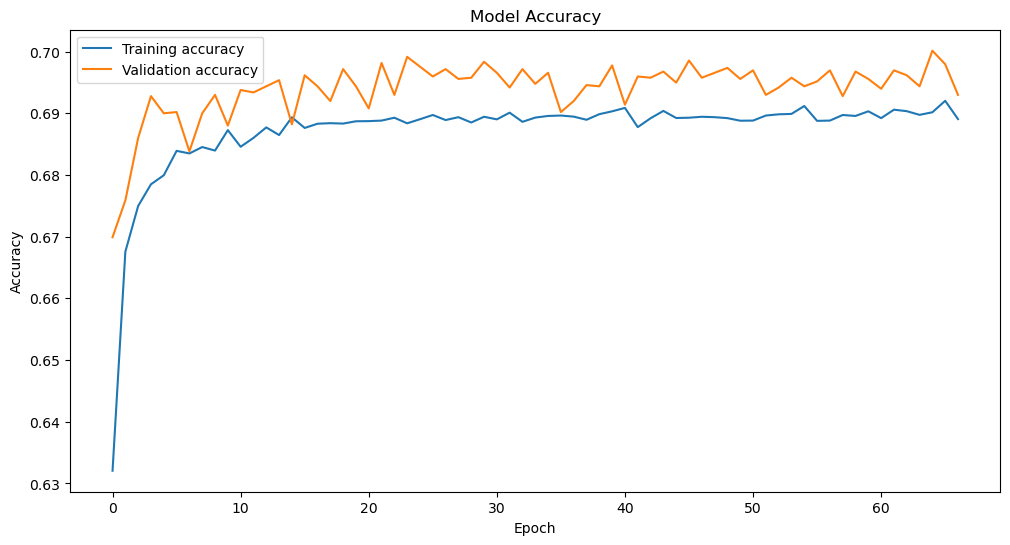

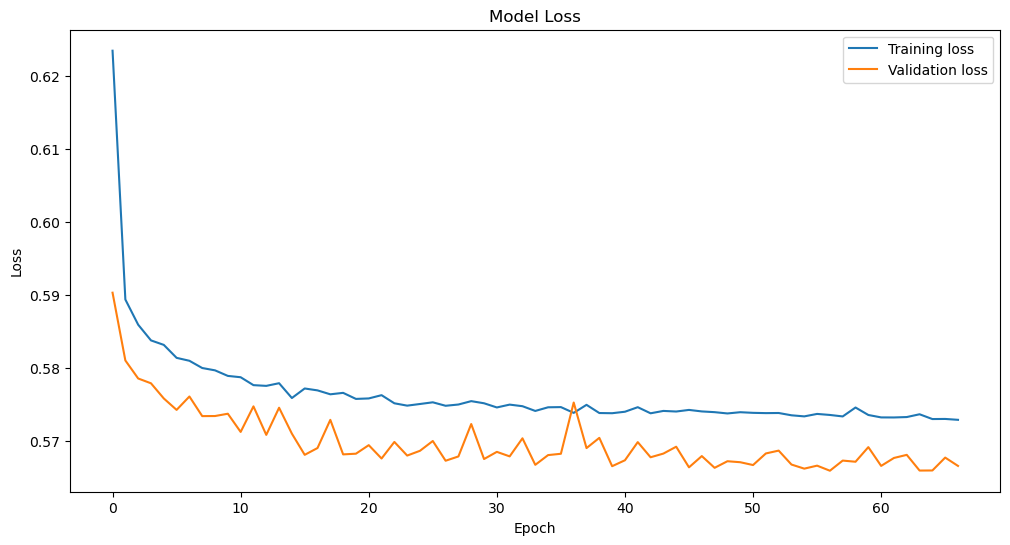

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure(figsize=(12, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()
